<a href="https://colab.research.google.com/github/HeNeos/Reports-FIM-UNI/blob/master/MC516-C%C3%A1lculo%20por%20elementos%20finitos/PC%204/MC516_PC4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def NaiveMultiply(A,B):
    C = np.zeros((A.shape[0],B.shape[1]))
    for i in range(0,C.shape[0]):
        for j in range(0,C.shape[1]):
            aux = 0
            for k in range(0,A.shape[1]):
                aux += A[i][k]*B[k][j]
            C[i][j] = aux
    return C
 
def nextPowerofTwo(n):
    return int(2**(ceil(log2(n))))
 
def ModifyMatrix(A):
    newA = A
    if(A.shape[1]%2 == 1):
        aux = np.zeros((A.shape[0],A.shape[1]+1))
        aux = np.insert(A,A.shape[1],0,axis=1)
        newA = aux
    if(newA.shape[0]%2 == 1):
        aux = np.zeros((newA.shape[0]+1,newA.shape[1]))
        aux = np.insert(newA,newA.shape[0],0,axis=0)
        newA = aux
    return newA
 
def FastMultiply(oldA,oldB):
    rows = oldA.shape[0]
    columns = oldB.shape[1]
    if(rows <= 2 or columns <=2 or oldA.shape[1] <= 2 or oldB.shape[0] <= 2):
        return np.matmul(oldA,oldB)
    
    A = ModifyMatrix(oldA)
    B = ModifyMatrix(oldB)
    N1 = A.shape[0]
    N2 = A.shape[1]
    N3 = B.shape[0]
    N4 = B.shape[1]
    
 
    a = A[0:N1//2,0:N2//2]
    b = A[0:N1//2,N2//2:N2//2+N2//2]
    c = A[N1//2:N1//2+N1//2,0:N2//2]
    d = A[N1//2:N1//2+N1//2,N2//2:N2//2+N2//2]
    
    e = B[0:N3//2,0:N4//2]
    f = B[0:N3//2,N4//2:N4//2+N4//2]
    g = B[N3//2:N3//2+N3//2,0:N4//2]
    h = B[N3//2:N3//2+N3//2,N4//2:N4//2+N4//2]
    
    
    p1 = FastMultiply(a,(f-h))
    p3 = FastMultiply((c+d),e)
    p2 = FastMultiply((a+b),h)
    p4 = FastMultiply(d,(g-e))
    p5 = FastMultiply((a+d),(e+h))
    p6 = FastMultiply((b-d),(g+h))
    p7 = FastMultiply((a-c),(e+f))
    
    
    C = np.zeros((rows,columns))
    
    c11 = p5 + p4 - p2 + p6
    c12 = p1 + p2
    c21 = p3 + p4
    c22 = p1 + p5 - p3 - p7
    
 
    
    for i in range(0,N1//2):
        for j in range(0,N4//2):
            C[i][j] = c11[i][j]
            if(j + N4//2 < columns):
                C[i][j+N4//2] = c12[i][j]
            if(i + N1//2 < rows):
                C[i+N1//2][j] = c21[i][j]
                if(j + N4//2 < columns):
                    C[i+N1//2][j+N4//2] = c22[i][j]
    return C

In [3]:
def conjugate_grad(A, b, x=None):
    n = b.shape[0]
    if not x:
        x = np.ones((n,1))
    r = np.dot(A, x) - b
    p = - r
    r_k_norm = FastMultiply(np.transpose(r), r)
    for i in range(2*n):
        Ap = np.dot(A, p)
        
        alpha = r_k_norm /FastMultiply(np.transpose(p), Ap)
        x += alpha * p
        r += alpha * Ap
        r_kplus1_norm = FastMultiply(np.transpose(r), r)
        beta = r_kplus1_norm / r_k_norm
        r_k_norm = r_kplus1_norm
        p = beta * p - r
    return x

In [4]:
NodesCondition = []
ForcesCondition = []

def AllAngle(f,s):
    L = DistanceNodes(f,s)
    C = []
    for i in range(3):
        C.append((s[i]-f[i])/L)
    C = np.arccos(np.array(C))
    return [C,L]

def DistanceNodes(f,s):
    return np.sqrt((s[0]-f[0])**2+(s[1]-f[1])**2+(s[2]-f[2])**2)

def SingleAngle(f,s):
    if(s[0] == f[0]):
        aux = np.pi/2
        if(s[1] < f[1]):
             aux *= -1
        return aux
    else:
        aux = np.arctan((s[1]-f[1])/(s[0]-f[0]))
    if(aux < 0 and s[1] > f[1]):
        aux += np.pi
    if(s[1] < f[1]):
        aux += np.pi
        if(s[0] > f[0]):
            aux += np.pi
    return aux
 
 
def UBoundaryCondition(nU,u,i):
    nU[i][0] = u
    NodesCondition.append(i)
 
def FBoundaryCondition(nF,f,i):
    nF[i][0] += f
    ForcesCondition.append(i)
    
def AssemblyStiffness(nStiffnessMatrix,k,i,j):
    for p in range(0,3):
        for m in range(0,3):
            nStiffnessMatrix[3*i+p][3*i+m] += k[p][m]
            nStiffnessMatrix[3*i+p][3*j+m] += k[p][3+m]
            nStiffnessMatrix[3*j+p][3*i+m] += k[p+3][m]
            nStiffnessMatrix[3*j+p][3*j+m] += k[p+3][3+m]
 
def Initialize(nStiffnessMatrix,nU,nF):
    for i in range(0,Nodes):
        nU[i][0] = 0
        nF[i][0] = 0
    for i in range(0,NumberOfElement):
        AssemblyStiffness(nStiffnessMatrix,K[i],int(Elements[i][0]),int(Elements[i][1]))

def TMatrix(nT,i,angle):
    nT[2*i][2*i] = np.cos(angle)
    nT[2*i][2*i+1] = np.sin(angle)
    nT[2*i+1][2*i] = -np.sin(angle)
    nT[2*i+1][2*i+1] = np.cos(angle)

def ApplyT(nStiffnessMatrix, nT):
    return FastMultiply(FastMultiply(nT,nStiffnessMatrix),np.transpose(nT))

def PreSolvingStiffness(nStiffnessMatrix):
    nsize = Nodes-len(NodesCondition)
    newStiffness = np.zeros((nsize,nsize))
    contr = -1
    for i in range(0,Nodes):
        contc = -1
        flagr = False
        for k in range(0,len(NodesCondition)):
            if(i == NodesCondition[k]):
                flagr = True
                break
        if(flagr):
            continue
        contr += 1
        for j in range(0,Nodes):
            flagc = False
            for k in range(0,len(NodesCondition)):
                if(j == NodesCondition[k]):
                    flagc = True
                    break
            if(flagc):
                continue
            contc += 1
            newStiffness[contr][contc] = nStiffnessMatrix[i][j]
    return newStiffness
 
 
def PreSolvingF(nF,nS,nU):
    nsize = Nodes-len(NodesCondition)
    newF = np.zeros(nsize).reshape(nsize,1)
    contr = -1
    for i in range(0,Nodes):
        flagr = False
        for k in range(0,len(NodesCondition)):
            if(i == NodesCondition[k]):
                flagr = True
                break
        if(flagr):
            for k in range(0,Nodes):
                nF[k][0] = nF[k][0]-nS[k][i]*nU[i][0]
            continue
 
            
    for i in range(0,Nodes):
        flagr = False
        for k in range(0,len(NodesCondition)):
            if(i == NodesCondition[k]):
                flagr = True
                break
        if(flagr):
            continue
        contr += 1
        newF[contr][0] = nF[i][0]
    
    return newF
                      
 
def Solve(nStiffnessMatrix,nU,nF):
    newStiffness = PreSolvingStiffness(nStiffnessMatrix)
    newF = PreSolvingF(nF,nStiffnessMatrix,nU)
    u = conjugate_grad(newStiffness,newF)    
    contr = -1
    for i in range(0,Nodes):
        flagr = False
        for k in range(0,len(NodesCondition)):
            if(i == NodesCondition[k]):
                flagr = True
                break
        if(flagr):
            continue
        contr += 1
        nU[i][0] = u[contr][0]
    nnF = FastMultiply(StiffnessMatrix,nU)
    return nU,nnF

In [5]:
NodesCondition = []
Nodes = 12
Nodes *= 3
NumberOfElement = 33

E = 2.1e5 #MPA
K = []
L = []
P_A = 10000 #N
P_B = 8000 #N
l1 = 600#mm
l2 = 500#mm
alpha = 30*np.pi/180
beta = 70*np.pi/180

PosNodes = np.array([(0,0,0),(l1,0,0),(2*l1,0,0),(3*l1,0,0),(l1,-l1*np.tan(alpha),0),(2*l1,-l1*np.tan(alpha),0),
                        (0,0,-l2),(l1,0,-l2),(2*l1,0,-l2),(3*l1,0,-l2),(l1,-l1*np.tan(alpha),-l2),(2*l1,-l1*np.tan(alpha),-l2)])

Elements = np.array([(0,1),(0,4),(0,6),(0,10),
                     (1,2),(1,4),(1,6),(1,7),(1,8),(1,10),
                     (2,3),(2,4),(2,5),(2,8),(2,10),(2,11),
                     (3,5),(3,8),(3,9),(3,11),
                     (4,5),(4,10),
                     (5,10),(5,11),
                     (6,7),(6,10),
                     (7,8),(7,10),
                     (8,9),(8,10),(8,11),
                     (9,11),
                     (10,11)])
A = np.pi*25*25 #mm^2
for i in range(0,NumberOfElement):
    L.append(AllAngle(PosNodes[Elements[i][0]],PosNodes[Elements[i][1]]))

L = np.array(L)

for i in range(0,NumberOfElement):
    l = L[i][1]
    angles = np.cos(L[i][0])
    aux = np.zeros((6,6))
    w = np.zeros((3,3))
    for j in range(0,3):
        for k in range(0,3):
            w[j][k] = angles[j]*angles[k]
    for k in range(6):
        for j in range(6):
            s = 1
            if k >= 3:
                s *= -1
            if j >= 3:
                s *= -1
            aux[k][j] = w[k%3][j%3]*s
    aux = aux*E*A/l
    K.append(aux)


StiffnessMatrix = np.zeros((Nodes,Nodes))

U = np.zeros(Nodes).reshape(Nodes,1)
F = np.zeros(Nodes).reshape(Nodes,1)

Initialize(StiffnessMatrix,U,F)

#Node in UBoundary = Node*3+(x=0,y=1,z=2)
UBoundaryCondition(U,0,3*0+0) #Nodo 0 en X
UBoundaryCondition(U,0,3*0+1) #Nodo 0 en Y
UBoundaryCondition(U,0,3*0+2) #Nodo 0 en Z

UBoundaryCondition(U,0,3*6+0) #Nodo 6 en X
UBoundaryCondition(U,0,3*6+1) #Nodo 6 en Y
UBoundaryCondition(U,0,3*6+2) #Nodo 6 en Z

UBoundaryCondition(U,0,3*3+1) #Nodo 3 en Y
UBoundaryCondition(U,0,3*3+2) #Nodo 3 en Z

UBoundaryCondition(U,0,3*9+1) #Nodo 9 en Y
UBoundaryCondition(U,0,3*9+2) #Nodo 9 en Z

FBoundaryCondition(F,-P_A/2,3*4+1) #Nodo 4 en Y
FBoundaryCondition(F,-P_A/2,3*10+1) #Nodo 10 en Y

FBoundaryCondition(F,P_B*np.sin(beta)/2,3*5+0) #Nodo 5 en X
FBoundaryCondition(F,P_B*np.sin(beta)/2,3*11+0) #Nodo 11 en X

FBoundaryCondition(F,-P_B*np.cos(beta)/2,3*5+1) #Nodo 5 en Y
FBoundaryCondition(F,-P_B*np.cos(beta)/2,3*11+1) #Nodo 11 en Y

U,F=Solve(StiffnessMatrix,U,F)
nU = np.zeros((U.shape[0]//3,3))
nF = np.zeros((U.shape[0]//3,3))
for i in range(U.shape[0]//3):
    for j in range(3):
        nU[i][j] = U[3*i+j][0]
        nF[i][j] = F[3*i+j][0]
        if abs(nU[i][j]) < 1e-7:
            nU[i][j] = 0.0
        if abs(nF[i][j]) < 1e-7:
            nF[i][j] = 0.0

#print("Stiffness Matrix:\n",StiffnessMatrix,'\n')
print("Displacements:\n",nU,'\n')
print("Forces:\n",nF)

Displacements:
 [[ 0.          0.          0.        ]
 [-0.00607338 -0.04190559  0.01042652]
 [-0.01074801 -0.03483282  0.00253575]
 [-0.0147365   0.          0.        ]
 [-0.00896678 -0.04222984  0.0181459 ]
 [-0.00057163 -0.03471018  0.00730906]
 [ 0.          0.          0.        ]
 [-0.00692081 -0.05129198  0.01042652]
 [-0.01384163 -0.04263057  0.00166836]
 [-0.01816938  0.          0.        ]
 [-0.01156607 -0.05129198  0.0181459 ]
 [-0.00056026 -0.04204056  0.00792733]] 

Forces:
 [[-3403.09996555  4374.50697111   580.26841796]
 [    0.             0.             0.        ]
 [    0.             0.             0.        ]
 [    0.          1993.57360219    98.797366  ]
 [    0.         -5000.             0.        ]
 [ 3758.77048314 -1368.0805733      0.        ]
 [-4114.44100073  4650.9648446   -679.06578396]
 [    0.             0.             0.        ]
 [    0.             0.             0.        ]
 [    0.          1717.1157287      0.        ]
 [    0.         -5000. 

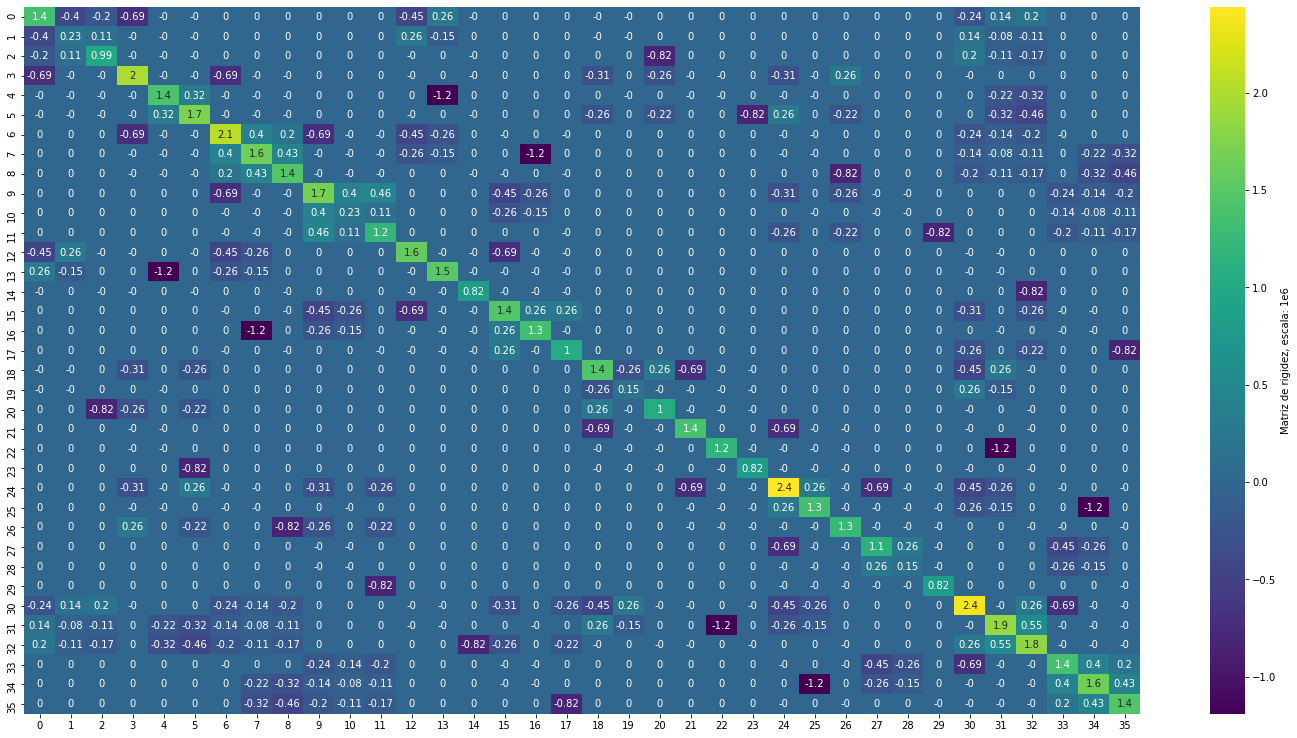

In [6]:
plt.figure(figsize=(25,13))
sns.heatmap(np.around(StiffnessMatrix/1e6,2),annot=True,cmap='viridis',cbar_kws={'label':'Matriz de rigidez, escala: 1e6'})
#plt.savefig('/content/drive/My Drive/Colab Notebooks/MC516/PC4/stiffness.pdf')

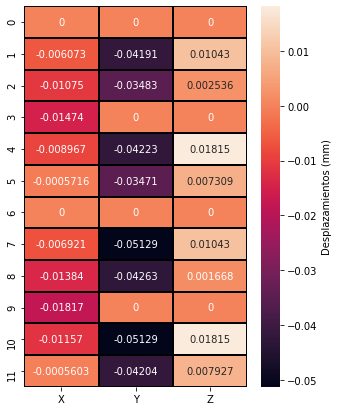

In [7]:
_xaxis = ['X','Y','Z']
plt.figure(figsize=(5,7))
sns.heatmap(nU,xticklabels=_xaxis,annot=True,fmt='.4g',linewidths=1,linecolor='black',cbar_kws={'label':'Desplazamientos (mm)'})
#plt.savefig('/content/drive/My Drive/Colab Notebooks/MC516/PC4/displacements.pdf')

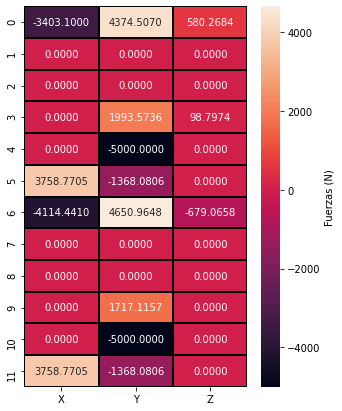

In [8]:
plt.figure(figsize=(5,7))
sns.heatmap(nF,xticklabels=_xaxis,annot=True,linewidths=1,linecolor='black',cbar_kws={'label':'Fuerzas (N)'},fmt='.4f')
#plt.savefig('/content/drive/My Drive/Colab Notebooks/MC516/PC4/forces.pdf')

In [9]:
F_R = np.sqrt(nF[:,0]*nF[:,0] + nF[:,1]*nF[:,1] + nF[:,2]*nF[:,2])
F_R = F_R.reshape((F_R.shape[0],1))
S = np.zeros((NumberOfElement,1))
for i in range(0,NumberOfElement):
    l = L[i,1]
    inp = Elements[i][0]
    out = Elements[i][1]
    aux = -(np.cos(L[i,0][0])*nU[inp][0]+np.cos(L[i,0][1])*nU[inp][1]+np.cos(L[i,0][2])*nU[inp][2])
    aux += (np.cos(L[i,0][0])*nU[out][0]+np.cos(L[i,0][1])*nU[out][1]+np.cos(L[i,0][2])*nU[out][2])
    S[i][0] = aux*E/l
    if abs(S[i][0]) < 1e-8:
        S[i][0] = 0

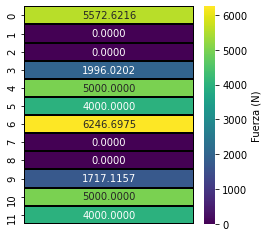

In [10]:
_xaxis = []
plt.figure(figsize=(3.8,4))
sns.heatmap(F_R,xticklabels=_xaxis,annot=True,linewidths=1,linecolor='black',cbar_kws={'label':'Fuerza (N)'},fmt='.4f',cmap='viridis')
#plt.savefig('/content/drive/My Drive/Colab Notebooks/MC516/PC4/f_r.pdf')